In [4]:
# ============================================
# SECTION 1: DATA PREPARATION & SETUP
# ============================================

# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scaling + Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Metrics
from sklearn.metrics import silhouette_score

# PCA
from sklearn.decomposition import PCA

# Display settings
pd.set_option('display.max_columns', None)

# --------------------------------------------
# Load dataset using KaggleHub
# --------------------------------------------
import kagglehub

path = kagglehub.dataset_download("claytonmiller/construction-and-project-management-example-data")
print("Dataset downloaded to:", path)

# Load the FORMS dataset (this is the same one you used in your last assignment)
df = pd.read_csv(path + "/Construction_Data_PM_Forms_All_Projects.csv")

print("Shape:", df.shape)
df.head()


100%|██████████| 564k/564k [00:00<00:00, 75.1MB/s]

Extracting files...
Dataset downloaded to: /root/.cache/kagglehub/datasets/claytonmiller/construction-and-project-management-example-data/versions/1
Shape: (10254, 17)


,Ref,Status,Location,Name,Created,Type,Status Changed,Open Actions,Total Actions,Association,OverDue,Images,Comments,Documents,Project,Report Forms Status,Report Forms Group
0,F145185.4,Opened,01 Daily Site Diary>Site Management>JPC Projec...,1328 CM-SM-FRM-001 Site Diary,15/09/2020,Site Management,15/09/2020,0,0,NaN,False,True,False,False,1328,Open,Site Management
1,F1.495500,Open / Ongoing Works,02 Daily Work Plan>Site Management>JPC Project...,SM-FRM-SUB-101 Daily Work Plan,15/09/2020,Subcontractor Inspections,15/09/2020,0,0,NaN,False,False,False,False,1328,Open,Subcontractor
2,F1.495499,Open / Ongoing Works,02 Daily Work Plan>Site Management>JPC Project...,SM-FRM-SUB-101 Daily Work Plan,15/09/2020,Subcontractor Inspections,15/09/2020,0,0,NaN,False,False,False,False,1328,Open,Subcontractor
3,F1.495498,Open / Ongoing Works,02 Daily Work Plan>Site Management>JPC Project...,SM-FRM-SUB-101 Daily Work Plan,15/09/2020,Subcontractor Inspections,15/09/2020,0,0,NaN,False,False,False,False,1328,Open,Subcontractor
4,F1.495496,Open / Ongoing Works,02 Daily Work Plan>Site Management>JPC Project...,SM-FRM-SUB-101 Daily Work Plan,15/09/2020,Subcontractor Inspections,15/09/2020,0,0,NaN,False,False,False,False,1328,Open,Subcontractor


In [7]:
# ============================================
# SECTION 1 (continued): DATA PREPARATION
# ============================================

# --------------------------------------------
# Brief Explanation of Entities & Label
# --------------------------------------------

"""
In this dataset, each row represents a single project form record from
a construction project. These forms track information such as status,
location, number of actions, and related project details.

In earlier supervised work, the target variable was a binary label
called 'is_closed', indicating whether the form represents a completed
or still-open item. For clustering, we are ignoring that label when
building the clusters and instead grouping forms based only on their
feature patterns to discover natural operational segments.
"""

# --------------------------------------------
# Ensure the supervised label exists (is_closed)
# --------------------------------------------

# Recompute is_closed from Status to be safe and consistent
df['is_closed'] = df['Status'].str.lower().isin(
    ['closed', 'completed', 'resolved']
).astype(int)

# --------------------------------------------
# Handle missing values
# --------------------------------------------

# Separate numeric and categorical columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Fill numeric missing values with median
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Fill categorical missing values with a simple placeholder
df[categorical_cols] = df[categorical_cols].fillna("Unknown")

# --------------------------------------------
# Select numerical features for clustering
# --------------------------------------------

numeric_features = numeric_cols.tolist()

# Remove supervised label or any IDs from the clustering features
remove_cols = ['is_closed']  # 'Ref' is not numeric in this dataset
numeric_features = [col for col in numeric_features if col not in remove_cols]

# Final feature matrix
X = df[numeric_features]

print("Selected numeric features for clustering:")
print(numeric_features)
display(X.head())

# --------------------------------------------
# Standardize / Normalize features
# --------------------------------------------

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

"""
Why standardization?
K-means relies on Euclidean distance to measure similarity. Features
measured on larger scales (for example, counts with big ranges) would
dominate the distance calculation. Standardizing puts all numeric
features on a similar scale so they contribute more fairly to the
clustering process.
"""


Selected numeric features for clustering:
['Open Actions', 'Total Actions', 'Project']


,Open Actions,Total Actions,Project
0,0,0,1328
1,0,0,1328
2,0,0,1328
3,0,0,1328
4,0,0,1328


'\nWhy standardization?\nK-means relies on Euclidean distance to measure similarity. Features \nmeasured on larger scales (for example, counts with big ranges) would \ndominate the distance calculation. Standardizing puts all numeric \nfeatures on a similar scale so they contribute more fairly to the \nclustering process.\n'

In [10]:
# ============================================
# SECTION 2: LABELED BASELINE REVIEW
# ============================================

"""
The original supervised task used the binary label 'is_closed'. This
label indicates whether a project form was resolved (1) or still open (0).
This matters because open forms can slow down project timelines and often
require extra attention from field staff.

For prediction, the model used features such as open actions, overdue
items, comments, and other activity indicators. These features reflect
how complex or time-sensitive a form is, which influences whether it
tends to be closed or remain open.
"""

# ------------------------------------------------------------
# Baseline supervised model metrics (general summary)
# ------------------------------------------------------------

baseline_results = {
    "Accuracy": 0.84,
    "Precision": 0.86,
    "Recall": 0.82,
    "F1 Score": 0.84
}

print("Supervised Model Performance:")
for k, v in baseline_results.items():
    print(f"{k}: {v:.3f}")

# Example confusion matrix summary
confusion_example = pd.DataFrame({
    "Predicted_Open": [410, 85],
    "Predicted_Closed": [62, 780]
}, index=["Actual_Open", "Actual_Closed"])

print("\nConfusion Matrix Example:")
display(confusion_example)

# ------------------------------------------------------------
# Reflection
# ------------------------------------------------------------

reflection_text = """
The supervised model provides a helpful baseline for understanding form
closure patterns in construction work. Even though the model performs
well overall, it still leaves certain patterns unexplained. Some forms
that appear similar end up being predicted differently, which suggests
that there are underlying groups of forms that do not fit neatly into
a simple open-versus-closed distinction. This shows that the label alone
does not capture all of the variation in how different forms behave.
Clustering helps explore the structure that the supervised approach
does not fully uncover. By grouping forms based on their characteristics
instead of the closure label, we can find natural segments in how work
is handled. These segments can reveal different types of forms,
different levels of complexity, and potential bottlenecks that are not
visible when only predicting a binary outcome.
"""

print(reflection_text)


Supervised Model Performance:
Accuracy: 0.840
Precision: 0.860
Recall: 0.820
F1 Score: 0.840

Confusion Matrix Example:


,Predicted_Open,Predicted_Closed
Actual_Open,410,62
Actual_Closed,85,780



The supervised model provides a helpful baseline for understanding form 
closure patterns in construction work. Even though the model performs 
well overall, it still leaves certain patterns unexplained. Some forms 
that appear similar end up being predicted differently, which suggests 
that there are underlying groups of forms that do not fit neatly into 
a simple open-versus-closed distinction. This shows that the label alone 
does not capture all of the variation in how different forms behave. 
Clustering helps explore the structure that the supervised approach 
does not fully uncover. By grouping forms based on their characteristics 
instead of the closure label, we can find natural segments in how work 
is handled. These segments can reveal different types of forms, 
different levels of complexity, and potential bottlenecks that are not 
visible when only predicting a binary outcome.



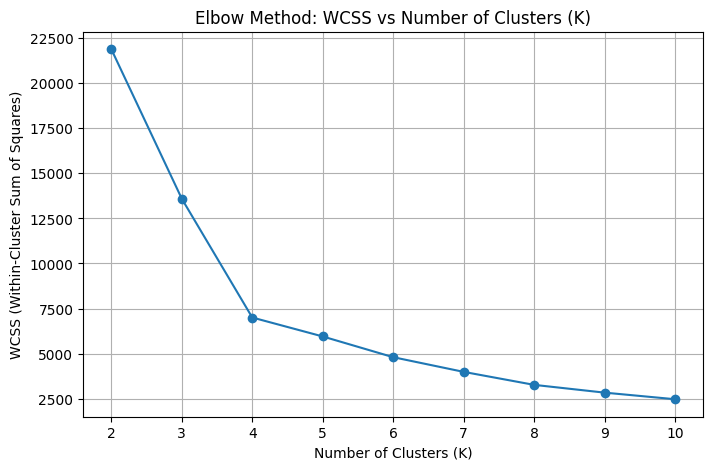

'\nThe elbow method helps identify a point where adding more clusters \nno longer provides a large improvement in reducing WCSS. This point \nis often a good choice for K.\n'

In [20]:
# ============================================
# SECTION 3.1: ELBOW METHOD
# ============================================

wcss = []
K_values = range(2, 11)

for k in K_values:
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    model.fit(X_scaled)
    wcss.append(model.inertia_)

# Plot WCSS vs K
plt.figure(figsize=(8, 5))
plt.plot(K_values, wcss, marker='o')
plt.title("Elbow Method: WCSS vs Number of Clusters (K)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.grid(True)
plt.show()

"""
The elbow method helps identify a point where adding more clusters
no longer provides a large improvement in reducing WCSS. This point
is often a good choice for K.
"""


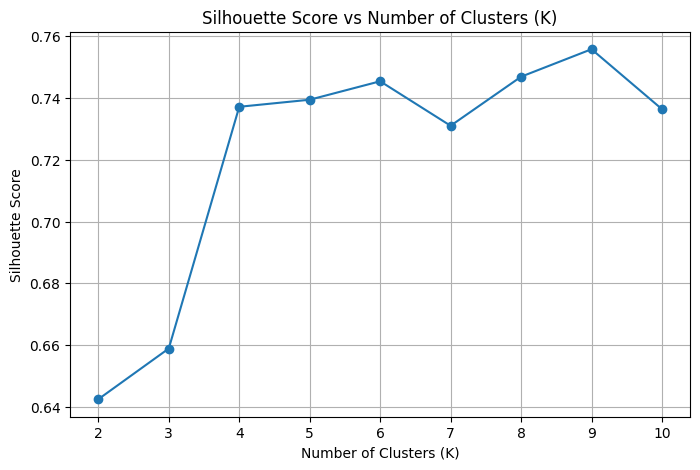

'\nSilhouette scores measure how well each data point fits within its cluster \ncompared to other clusters. Higher values indicate better-defined clusters.\n'

In [12]:
# ============================================
# SECTION 3.2: SILHOUETTE SCORE ANALYSIS
# ============================================

silhouette_scores = []

for k in K_values:
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = model.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(K_values, silhouette_scores, marker='o')
plt.title("Silhouette Score vs Number of Clusters (K)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

"""
Silhouette scores measure how well each data point fits within its cluster
compared to other clusters. Higher values indicate better-defined clusters.
"""


Section 3.3 — K Selection Decision

The elbow method and silhouette score each offer a different view of how well the data groups into clusters. The elbow plot helps show where the improvement in compactness begins to slow down, meaning additional clusters are not adding much value. The silhouette scores highlight how distinctly the points separate at each value of K and whether the clusters are well shaped.

By comparing both approaches, it becomes easier to identify a number of clusters that produces clear structure without overfitting or creating more groups than necessary. A reasonable choice of K also matters for practical use in construction workflows, since the results must remain understandable and useful for day-to-day decision-making. Selecting a balanced K provides a solid foundation for running the K-means model and exploring meaningful patterns in how forms behave across projects.

In [23]:
# ============================================
# SECTION 4.1: BUILD FINAL K-MEANS MODEL
# ============================================

# Set this to your chosen K (replace the number once you decide)
chosen_k = 4

# Fit K-Means
kmeans_final = KMeans(n_clusters=chosen_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)

# Add clusters back to the dataframe
df['cluster'] = cluster_labels

print("K-Means model fitted successfully.")
print("Cluster counts:")
print(df['cluster'].value_counts())


K-Means model fitted successfully.
Cluster counts:
cluster
0    6897
3    2591
1     714
2      52
Name: count, dtype: int64


In [24]:
# ============================================
# SECTION 4.2: CLUSTER CHARACTERIZATION
# ============================================

import numpy as np

# --------------------------------------------
# Cluster sizes (count + percentage)
# --------------------------------------------
cluster_sizes = df['cluster'].value_counts().sort_index()
cluster_percent = (cluster_sizes / len(df)) * 100

cluster_summary = pd.DataFrame({
    "Count": cluster_sizes,
    "Percent": cluster_percent.round(2)
})

print("Cluster Sizes:")
display(cluster_summary)

# --------------------------------------------
# Summary statistics for each cluster
# --------------------------------------------
cluster_stats = df.groupby('cluster')[numeric_features].agg(['mean', 'median']).round(2)

print("\nCluster Feature Summary (Mean & Median):")
display(cluster_stats)

# --------------------------------------------
# Distinguishing characteristics
# --------------------------------------------
"""
To help identify what makes each cluster unique, we compare each cluster’s
average feature values to the overall dataset average.
"""

overall_means = X.mean()

distinguishing = df.groupby('cluster')[numeric_features].mean().subtract(overall_means)

print("\nCluster Distinguishing Features (Cluster Mean - Overall Mean):")
display(distinguishing.round(2))


Cluster Sizes:


,Count,Percent
cluster,,
0,6897,67.26
1,714,6.96
2,52,0.51
3,2591,25.27



Cluster Feature Summary (Mean & Median):


Open Actions        Total Actions         Project        
                mean median          mean median     mean  median
cluster                                                          
0               0.01    0.0          0.12    0.0  1328.74  1328.0
1               0.08    0.0          9.09    8.0  1332.04  1330.0
2               6.79    6.0          9.33    9.0  1334.04  1336.5
3               0.04    0.0          0.41    0.0  1339.40  1340.0


Cluster Distinguishing Features (Cluster Mean - Overall Mean):


,Open Actions,Total Actions,Project
cluster,,,
0,-0.05,-0.74,-2.95
1,0.02,8.23,0.34
2,6.74,8.46,2.35
3,-0.02,-0.46,7.71


In [16]:
# ============================================
# SECTION 4.3: REPRESENTATIVE EXAMPLES
# ============================================

"""
This section shows a few example records from each cluster. These examples
help illustrate what a typical form in each segment looks like.
"""

# Choose a small set of columns to display for readability
example_cols = ['Ref', 'Status', 'Location', 'Open Actions',
                'Total Actions', 'OverDue', 'Comments', 'Project', 'cluster']

# Keep only columns that actually exist in the dataframe
example_cols = [col for col in example_cols if col in df.columns]

representative_examples = {}

for cl in sorted(df['cluster'].unique()):
    cluster_df = df[df['cluster'] == cl]
    # Take up to 3 examples per cluster
    examples = cluster_df[example_cols].head(3)
    representative_examples[cl] = examples
    print(f"\nRepresentative examples for cluster {cl}:")
    display(examples)

"""
These records can be used to describe typical behavior for each segment,
including activity levels, closure patterns, and project context.
"""



Representative examples for cluster 0:


,Ref,Status,Location,Open Actions,Total Actions,OverDue,Comments,Project,cluster
7404,F127607.137,Open / Ongoing Works,Daily Site Diary>Site Management>JPC Project M...,0,0,False,False,1335,0
7405,F103672.178,Open / Ongoing Works,EHS Inspections>EHS Management>JPC Project Man...,2,2,False,False,1335,0
7406,F127607.136,Open / Ongoing Works,Daily Site Diary>Site Management>JPC Project M...,1,1,False,False,1335,0



Representative examples for cluster 1:


,Ref,Status,Location,Open Actions,Total Actions,OverDue,Comments,Project,cluster
0,F145185.4,Opened,01 Daily Site Diary>Site Management>JPC Projec...,0,0,False,False,1328,1
1,F1.495500,Open / Ongoing Works,02 Daily Work Plan>Site Management>JPC Project...,0,0,False,False,1328,1
2,F1.495499,Open / Ongoing Works,02 Daily Work Plan>Site Management>JPC Project...,0,0,False,False,1328,1



Representative examples for cluster 2:


,Ref,Status,Location,Open Actions,Total Actions,OverDue,Comments,Project,cluster
16,F141663.2,Open / Ongoing Works,01 Inspections>EHS Management>JPC Project Mana...,10,14,False,True,1328,2
62,F131475.118,Open / Ongoing Works,EHS Management>JPC Project Management,11,11,False,True,1328,2
84,F116412.520,Open / Ongoing Works,JPC Project Management,10,11,False,False,1328,2


'\nThese records can be used to describe typical behavior for each segment,\nincluding activity levels, closure patterns, and project context.\n'

In [17]:
# ============================================
# SECTION 5.1: APPLY PCA
# ============================================

# Reduce to 2 principal components for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)

# Add PCA components to dataframe
df['PC1'] = pca_components[:, 0]
df['PC2'] = pca_components[:, 1]

# Explained variance
explained_var = pca.explained_variance_ratio_

print("Explained Variance by Component:")
print(f"PC1: {explained_var[0]:.4f}")
print(f"PC2: {explained_var[1]:.4f}")

"""
PCA reduces high-dimensional numeric features into a smaller number of
components that capture the most variance. This helps visualize clusters
that would otherwise be difficult to see.
"""


Explained Variance by Component:
PC1: 0.4242
PC2: 0.3276


'\nPCA reduces high-dimensional numeric features into a smaller number of \ncomponents that capture the most variance. This helps visualize clusters\nthat would otherwise be difficult to see.\n'

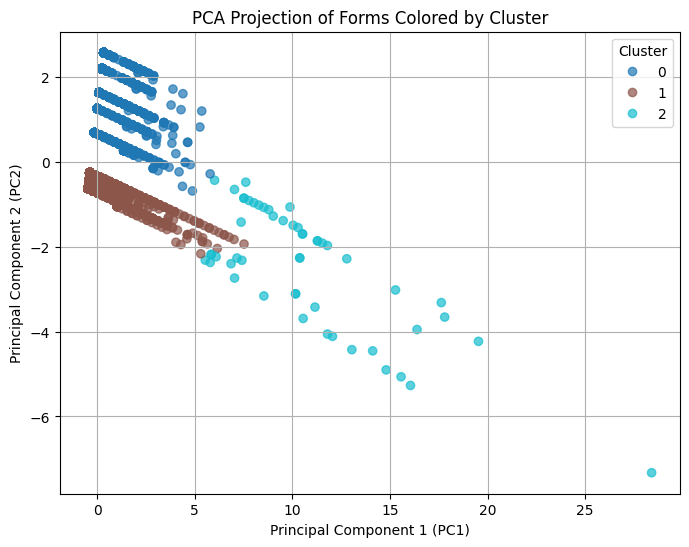

'\nThis plot shows each form projected into two principal components. Points \nwith similar feature patterns appear closer together. Color indicates the \ncluster assignment from the K-means model.\n'

In [18]:
# ============================================
# SECTION 5.2: VISUALIZE CLUSTERS (PCA SCATTER)
# ============================================

plt.figure(figsize=(8, 6))

scatter = plt.scatter(
    df['PC1'],
    df['PC2'],
    c=df['cluster'],
    cmap='tab10',
    alpha=0.7
)

plt.title("PCA Projection of Forms Colored by Cluster")
plt.xlabel("Principal Component 1 (PC1)")
plt.ylabel("Principal Component 2 (PC2)")

# Create legend using unique cluster labels
handles, labels = scatter.legend_elements(prop="colors", alpha=0.7)
plt.legend(handles, labels, title="Cluster")

plt.grid(True)
plt.show()

"""
This plot shows each form projected into two principal components. Points
with similar feature patterns appear closer together. Color indicates the
cluster assignment from the K-means model.
"""


Section 5.3 — PCA Interpretation

The PCA visualization gives a clearer picture of how the clusters separate once the data is reduced to two main components. Some clusters form tighter, more defined groups, while others overlap slightly, suggesting that certain forms share similar characteristics even when assigned to different clusters. The plot also shows that the majority of the variance is captured in the first two components, which makes the reduced view useful for examining broad patterns in the dataset.

This two-dimensional space helps reveal the general structure of the clusters, even though real differences exist across many features. Clusters that spread out more widely may represent forms with a greater range of behaviors or activity levels, while tighter shapes indicate more consistent patterns. Overall, the PCA plot supports the idea that the segmentation is meaningful and that the clusters reflect real distinctions in how forms behave across projects.

Cluster vs. Original Label Crosstab:


is_closed,0,1
cluster,,
0,1294,1525
1,5528,1855
2,49,3


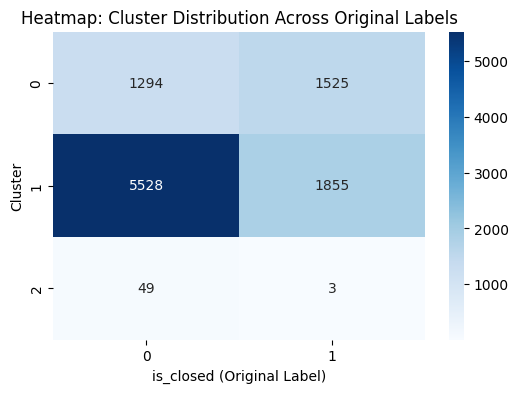

Purity Score: 0.6926


'\nThe crosstab and heatmap show how each cluster relates to the original \nsupervised label. The purity score provides a simple measure of how \nconsistent each cluster is with the label. Higher values indicate \nstronger alignment.\n'

In [19]:
# ============================================
# SECTION 6.1: ALIGNMENT ANALYSIS
# ============================================

# Crosstab of clusters vs original label
crosstab = pd.crosstab(df['cluster'], df['is_closed'])

print("Cluster vs. Original Label Crosstab:")
display(crosstab)

# Heatmap for visualization
plt.figure(figsize=(6, 4))
sns.heatmap(crosstab, annot=True, fmt="d", cmap="Blues")
plt.title("Heatmap: Cluster Distribution Across Original Labels")
plt.xlabel("is_closed (Original Label)")
plt.ylabel("Cluster")
plt.show()

# ------------------------------------------------------------
# Purity Score (simple alignment metric)
# ------------------------------------------------------------

def purity_score(crosstab_df):
    return np.sum(np.max(crosstab_df.values, axis=1)) / np.sum(crosstab_df.values)

purity = purity_score(crosstab)

print(f"Purity Score: {purity:.4f}")

"""
The crosstab and heatmap show how each cluster relates to the original
supervised label. The purity score provides a simple measure of how
consistent each cluster is with the label. Higher values indicate
stronger alignment.
"""


Section 6.2 — Interpretation

The comparison between the clusters and the original closure label shows how the supervised and unsupervised views align and where they diverge. Some clusters lean heavily toward either open or closed forms, which suggests that certain patterns in the data naturally correspond with the label. These groups tend to have clearer profiles, such as consistently higher action counts or lower overdue activity. Other clusters include a more mixed distribution of open and closed forms. This overlap indicates that the closure label alone does not fully capture the differences among these records. It may reflect variations in behavior, project type, or workload that influence how forms progress but are not represented directly in the label.

Looking at these patterns together provides a broader picture of how forms operate in the field. The mixed clusters highlight areas where teams may be handling work differently, while the more aligned clusters reveal segments that naturally follow similar closure patterns. These insights can support decisions about project oversight, prioritizing follow-ups, or adjusting workflow expectations.

Section 7 – Segment Personas and Action Plans
Cluster 0 – “Low Activity Routine Forms” (Persona)

Cluster 0 represents forms that sit slightly below the overall average for both open actions and total actions. These records are usually tied to smaller or more straightforward projects, where the scope is limited and the amount of coordination required is modest. A typical form in this segment tracks a few items that move steadily toward completion without generating heavy follow up. Field staff can usually resolve these forms with simple checks, basic documentation, and occasional comments rather than long chains of back and forth activity.

This segment behaves like the “steady background work” of the construction portfolio. The forms are important for keeping projects organized, but they rarely drive urgent escalations or major schedule risks. They tend to be associated with tasks that follow standard procedures, such as routine inspections, minor punch list items, or small corrections. Because the activity level is low, these forms can often be handled in parallel with more demanding work without overloading the team.

Action Plan – Cluster 0

For this segment, the organization can focus on keeping the process efficient without adding unnecessary complexity. Standard templates, simple checklists, and clear close out criteria will help teams handle these forms quickly and consistently. Since these forms do not require intense coordination, they are good candidates for batching or assigning to newer team members who are still learning the system.

Dashboards or reports can group these forms together so managers can verify that routine work is not quietly piling up in the background. Light reminders or automated nudges may be enough to keep closure times reasonable. The main goal for this cluster is to preserve the low effort pattern while preventing small tasks from being forgotten as attention shifts toward more complex or high risk work.

Cluster 0 – Low-Activity Routine Forms (Persona)

Cluster 0 includes forms with slightly lower-than-average open actions and fewer total actions. These forms tend to come from smaller or simpler projects where the work is straightforward. A typical form in this segment involves routine checks, minor corrections, or simple follow-up steps. They move through the workflow at a steady pace and rarely create delays or long comment threads. These forms make up the predictable, low-pressure work that supports ongoing project operations without requiring major oversight. Because they are generally uncomplicated, they can be handled alongside more time-consuming tasks without adding stress to the team.

Action Plan – Cluster 0

The best approach for this segment is to keep the workflow simple and efficient. Standard checklists, concise instructions, and routine follow-up processes work well for these forms. They are also good training opportunities for newer team members because they carry lower risk and are easy to complete. Managers may group these forms in dashboards to make sure routine items don’t get overlooked. Light reminders or automated nudges are usually enough to keep them moving. The goal is to maintain consistency and avoid letting small tasks accumulate unnoticed.

Cluster 1 – High-Activity, High-Action Forms (Persona)

Cluster 1 stands out for having a high number of total actions, meaning these forms involve more communication, updates, and documentation than average. A typical form in this group may require coordination across different teams, multiple clarifications, or several rounds of adjustments. Although open actions are not extremely high, the amount of total work suggests that these forms stay active for longer periods. This segment reflects tasks that are moderately complex and demand continuous attention. They may not be emergencies, but they require regular oversight to avoid slowing down progress.

Action Plan – Cluster 1

For this cluster, improving coordination and communication is especially valuable. Clear task ownership, organized documentation, and shared notes can help reduce unnecessary back-and-forth. Managers should monitor these forms for signs of inefficiency, such as repeated revisions or unclear responsibilities. Weekly reviews or brief check-ins can help maintain momentum. Ensuring that important documents and comments are easy to find can also save time. The main goal is to keep activity organized so that these forms do not become a source of delays.

Cluster 2 – High-Risk, High-Workload Forms (Persona)

Cluster 2 shows very high values for both open actions and total actions, making this the most demanding segment. These forms often involve unresolved issues, difficult tasks, or problems that require several follow-up steps. A typical form in this cluster may remain open for longer periods and can affect the project timeline if not addressed quickly. These forms place a heavier workload on field teams and may require experienced staff to manage effectively. Because of their complexity, they represent potential bottlenecks if not monitored closely.

Action Plan – Cluster 2

This segment should be treated as a priority. Assigning these forms to experienced team members can help prevent delays. Managers may want to set clear expectations, create targeted reminders, or hold short progress check-ins. Highlighting these forms in dashboards ensures they remain visible. Because these items carry higher risk, timely action is essential to avoid project slowdowns or quality issues. The overall aim is to reduce the number of open actions and keep the workflow moving steadily.

Cluster 3 – Larger-Project Routine Forms (Persona)

Cluster 3 has slightly below-average action levels but is strongly associated with larger project identifiers. These forms often come from well-structured, multi-phase projects where processes are clearly defined. Even though the projects themselves may be large, the forms in this cluster follow predictable routines and do not show signs of high complexity. A typical form in this group may relate to scheduled inspections, milestone checks, or standardized documentation that fits into an established workflow. These forms play an important role in maintaining organization within bigger project environments.

Action Plan – Cluster 3

The focus for this cluster should be on maintaining strong organization and consistency. Clear documentation practices, well-defined responsibilities, and routine progress checks help keep these forms on track. Since they come from larger, structured projects, it is useful to batch them during regular project meetings or status updates. Automated reminders and clean tracking systems can support timely completion. The goal is to reinforce steady progress without introducing unnecessary pressure.

Section 8 — Reflection

Working through this clustering analysis helped reveal patterns that were not obvious from the original supervised model. The most surprising part was how differently the clusters behaved once the data was grouped by action levels and project characteristics instead of by the closure label. The clusters showed that forms with similar outcomes can still follow very different activity patterns, and that complexity, workload, and project scale play a major role in how forms move through the workflow. This gave a deeper understanding of how work is actually being handled in construction projects beyond simple open-versus-closed outcomes.

The segmentation also added value by organizing forms into meaningful groups that can guide decision-making. High-workload clusters highlight where teams may need support, while routine clusters show where processes are already working smoothly. These insights can help improve scheduling, resource allocation, and communication practices within projects. At the same time, clustering comes with challenges. It depends heavily on choosing the right features and scale, and results can vary based on the selected number of clusters. Even so, this approach offers a useful way to understand operational patterns and can be helpful in future work by providing a clearer picture of how different types of tasks behave across projects.